In [2]:
import os

import emcee
import numpy as np
from astropy.io import fits, ascii
from eddy.fit_cube import rotationmap
from matplotlib import pyplot as plt

In [3]:
# target
t = 'HD_100453'
iso = '12CO' # isotopologue

# Path to data (FITS file)
path = '../../data/'
path_data = f"../../data/HD_100453/ALMA/HD_100453_12CO32_v0.fits"
path_uncertainties = f"../../data/HD_100453/ALMA/HD_100453_12CO32_dv0.fits"

# Path to database where results are stored
path_working_place = '../../workplace/outer_disks/mcmc_fitting/'

In [4]:
# load stellar parameters
stellar_parameters = ascii.read(os.path.join(path, 'sample_properties', 'stellar_properties.dat'))
stellar_masses = ascii.read(os.path.join(path, 'sample_properties', 'stellar_masses.dat'))
fit_parameters = ascii.read(os.path.join(path, 'sample_properties', 'fit_parameters_outer_disks.dat'))

In [5]:
# ---- MCMC parameters (current numbers for test purposes, choose larger numbers for actual simulations)
nwalkers = 50 # 100
nburnin = 200 # 2000
nsteps = 200 # 2000
iterations = 2

In [6]:
# how to fit the disk
# mode = 'thin'   # flat disk
mode = 'thick'    # disk with height profile

In [7]:
# ---- fitting parameters
p0 = {'thin': {
    'HD_100453': [0.01, -0.04, 30., 329., 5.2e3],
}, 'thick': {}}

for tmp_key in p0['thin'].keys():
    p0['thick'][tmp_key] = list(np.append(p0['thin'][tmp_key], [0., 0.]))

In [8]:
mask_fit_params = (fit_parameters['NAME'].data == t) & (fit_parameters['ISO'].data == iso)

In [9]:
# create working place directory if it does not exist
if not os.path.isdir(os.path.join(path_working_place, t, iso, mode)):
    print(f'Creating direcotry: {os.path.join(path_working_place, t, iso, mode)}')
    os.makedirs(os.path.join(path_working_place, t, iso, mode))

In [10]:
downsample = fit_parameters['DOWNSAMPLING'].data[mask_fit_params][0]
if downsample=='None':
    downsample = None
else:
    downsample = int(downsample)

print(f'Downsampling: {downsample}')

Downsampling: 4


In [11]:
cube = rotationmap(path=path_data,
                   FOV=float(fit_parameters['FOV'].data[mask_fit_params][0]),
                   downsample=downsample,
                   uncertainty=path_uncertainties
                   )

In [12]:
# No downsampling for plots
cube_full = rotationmap(path=path_data,
                        FOV=float(fit_parameters['FOV'].data[mask_fit_params][0]),
                        downsample=None,
                        uncertainty=path_uncertainties)

In [13]:
# Dictionary to contain the disk parameters.
params = {}

# Start with the free variables in p0.

params['x0'] = 0
params['y0'] = 1
params['inc'] = 2
params['PA'] = 3
params['vlsr'] = 4
if mode == 'thick':
    params['z0'] = 5
    params['psi'] = 6

In [14]:
# Fix the other parameters. All values which are to be fixed must be floats.
params['dist'] = 1000 / stellar_parameters['Plx'].data[stellar_parameters['NAME'].data == t]
params['mstar'] = stellar_masses['MASS'].data[stellar_masses['NAME'].data == t]
params['beam'] = False

Assuming:
	p0 = [x0, y0, inc, PA, vlsr, z0, psi].
Starting positions:
	p0 = ['1.00e-02', '-4.00e-02', '3.00e+01', '3.29e+02', '5.20e+03', '0.00e+00', '0.00e+00']


100%|██████████| 400/400 [00:37<00:00, 12.36it/s]


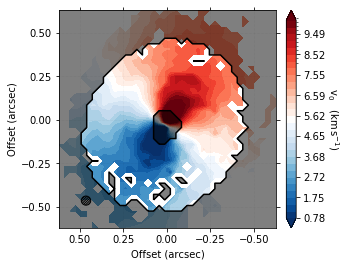

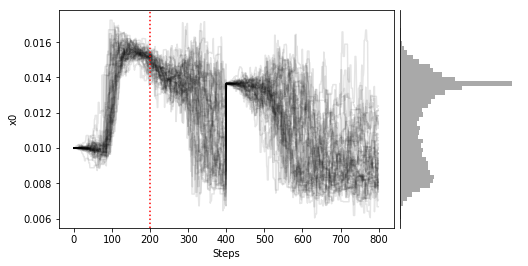

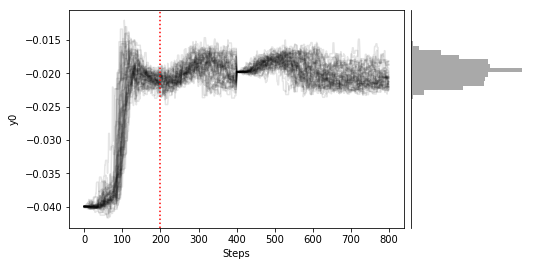

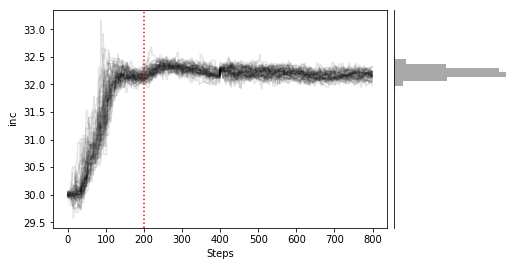

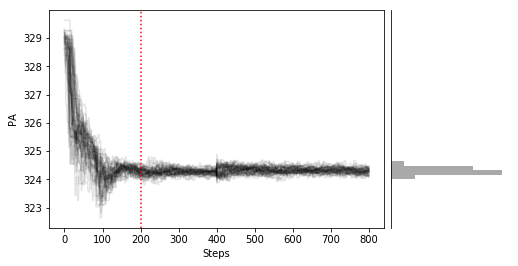

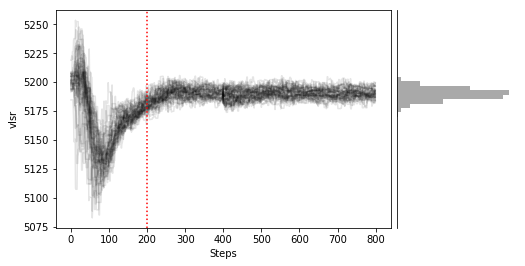

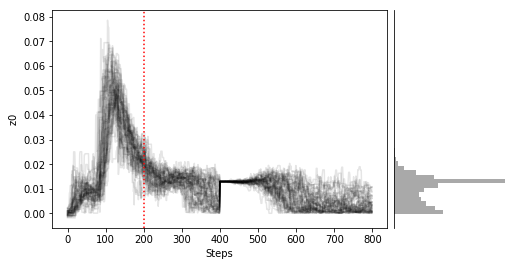

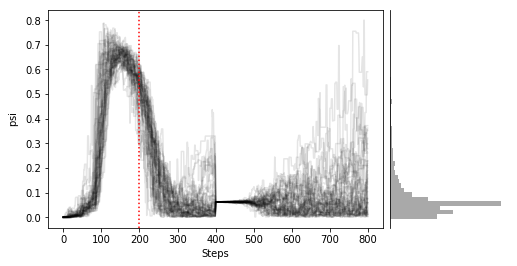

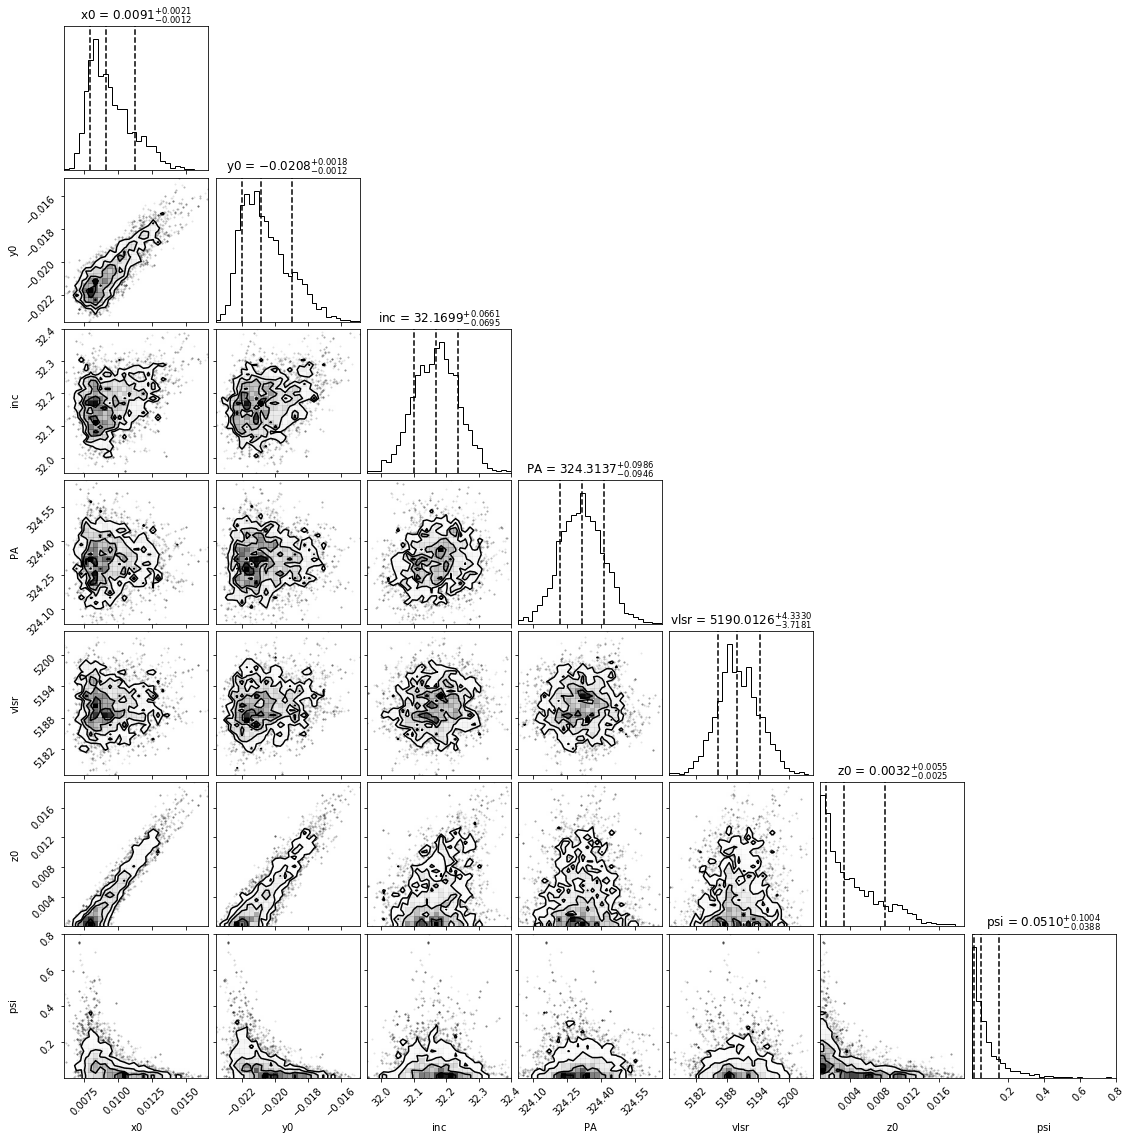

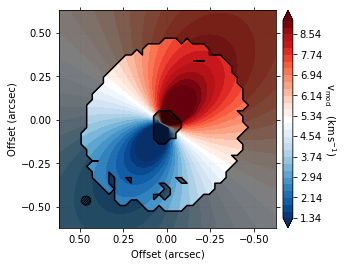

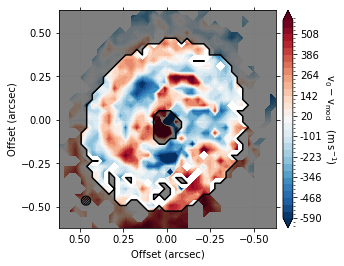

In [15]:
if not os.path.exists(os.path.join(path_working_place, t, iso, mode, f"{t}_mcmc_fit.hdf5")):

    backend_mcmc = emcee.backends.HDFBackend(os.path.join(path_working_place, t, iso, mode, f"{t}_mcmc_fit.hdf5"))
    backend_mcmc.reset(nwalkers, len(p0[mode][t]))


    percentiles = cube.fit_map(p0=p0[mode][t],
                               params=params,
                               r_min=float(fit_parameters['r_min'].data[mask_fit_params][0]) * cube.bmaj,
                               r_max=float(fit_parameters['r_max'].data[mask_fit_params][0]),
                               optimize=True,
                               nwalkers=nwalkers,
                               nburnin=nburnin,
                               nsteps=nsteps,
                               scatter=1e-3,
                               plots=None,
                               returns=None,
                               pool=None,
                               emcee_kwargs={
                                   'backend': backend_mcmc,
                               },
                               niter=iterations)


In [16]:
sampler = emcee.backends.HDFBackend(os.path.join(path_working_place, t, iso, mode, f"{t}_mcmc_fit.hdf5"))
posteriors = sampler.get_chain(discard=(iterations - 1) * (nsteps + nburnin) + nburnin,
                               thin=1,
                               flat=True)

medians = cube_full._populate_dictionary(np.percentile(posteriors, q=50, axis=0), params)
medians = cube_full.verify_params_dictionary(medians)
medians['r_min'] = float(fit_parameters['r_min'].data[mask_fit_params][0]) * cube.bmaj
medians['r_max'] = float(fit_parameters['r_max'].data[mask_fit_params][0])
medians['abs_PA'] = False
medians['exclude_r'] = False
cube.ivar = cube._calc_ivar(cube._populate_dictionary(np.percentile(posteriors, q=50, axis=0), medians))
cube_full.ivar = cube_full._calc_ivar(cube_full._populate_dictionary(np.percentile(posteriors, q=50, axis=0), medians))

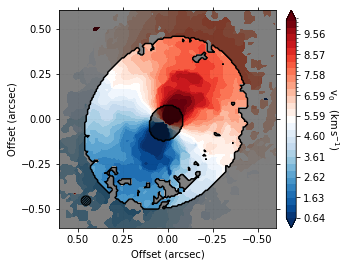

In [17]:
# Plot original data
fig_1 = cube_full.plot_data(levels=None,
               ivar=cube_full.ivar,
               return_fig=True)
plt.show()
plt.close(fig_1)

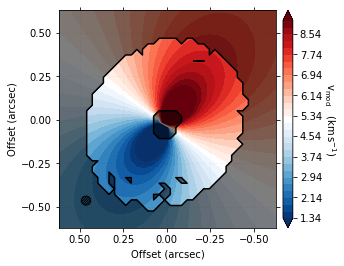

In [18]:
# Plot best-fit model
cube._plot_bestfit(params=medians,
                          ivar=cube.ivar,
                          residual=False,
                          return_ax=False)

fig_2 = plt.gcf()

plt.show()
plt.close(fig_2)

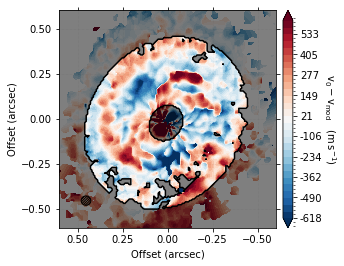

In [19]:
# Plot residuals
cube_full._plot_residual(params=medians,
                         ivar=cube_full.ivar,
                         return_ax=False)

fig_3 = plt.gcf()

plt.show()
plt.close(fig_3)

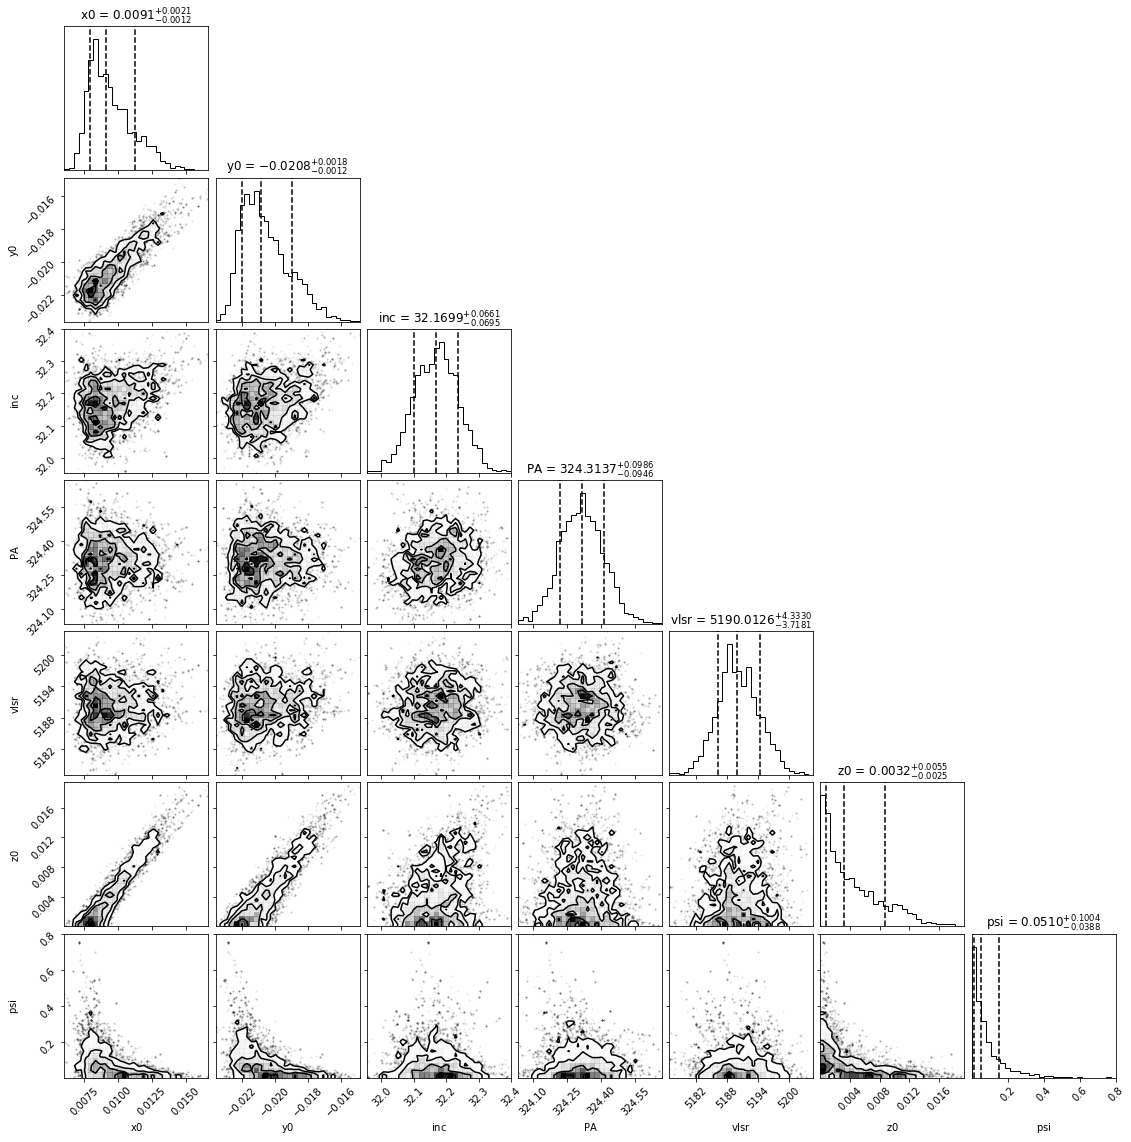

In [20]:
# Create corner plot
cube_full._plot_corner(posteriors,
                       cube_full._get_labels(params),
                       quantiles=None)

fig_4 = plt.gcf()

plt.show()
plt.close(fig_4)

In [21]:
# ---- Rescaled uncertainties
cube_rescaled = rotationmap(path=path_data,
                   FOV=float(fit_parameters['FOV'].data[mask_fit_params][0]),
                   downsample=downsample,
                   uncertainty=path_uncertainties.replace('.fits', '_rescaled.fits')
                   )

Found `r_min` in `params`. Overwriting value.
Found `r_max` in `params`. Overwriting value.
Assuming:
	p0 = [x0, y0, inc, PA, vlsr, z0, psi].
Starting positions:
	p0 = ['1.00e-02', '-4.00e-02', '3.00e+01', '3.29e+02', '5.20e+03', '0.00e+00', '0.00e+00']


100%|██████████| 400/400 [00:35<00:00, 11.28it/s]


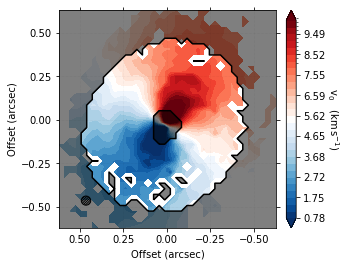

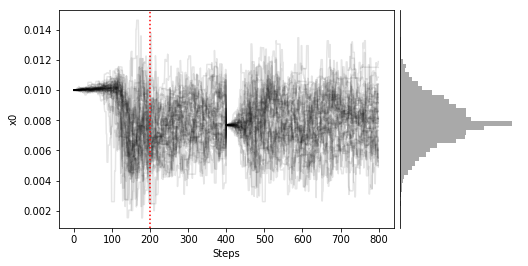

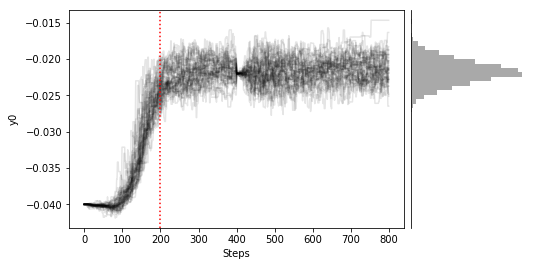

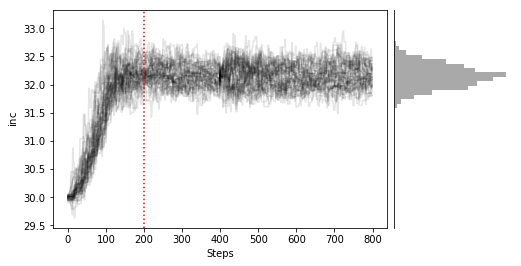

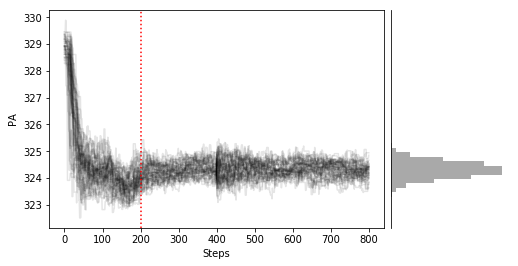

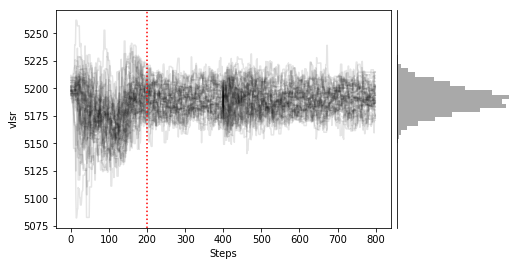

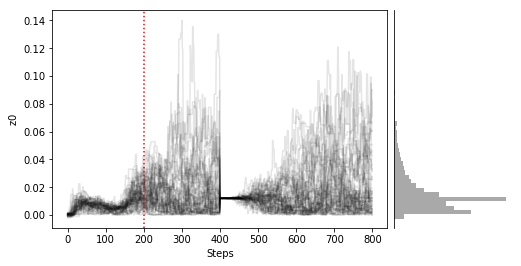

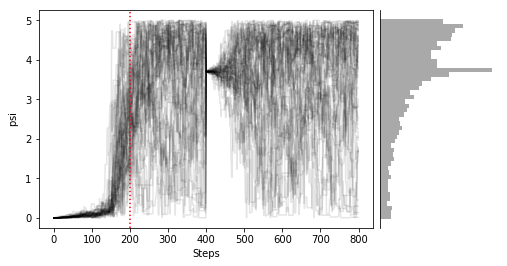

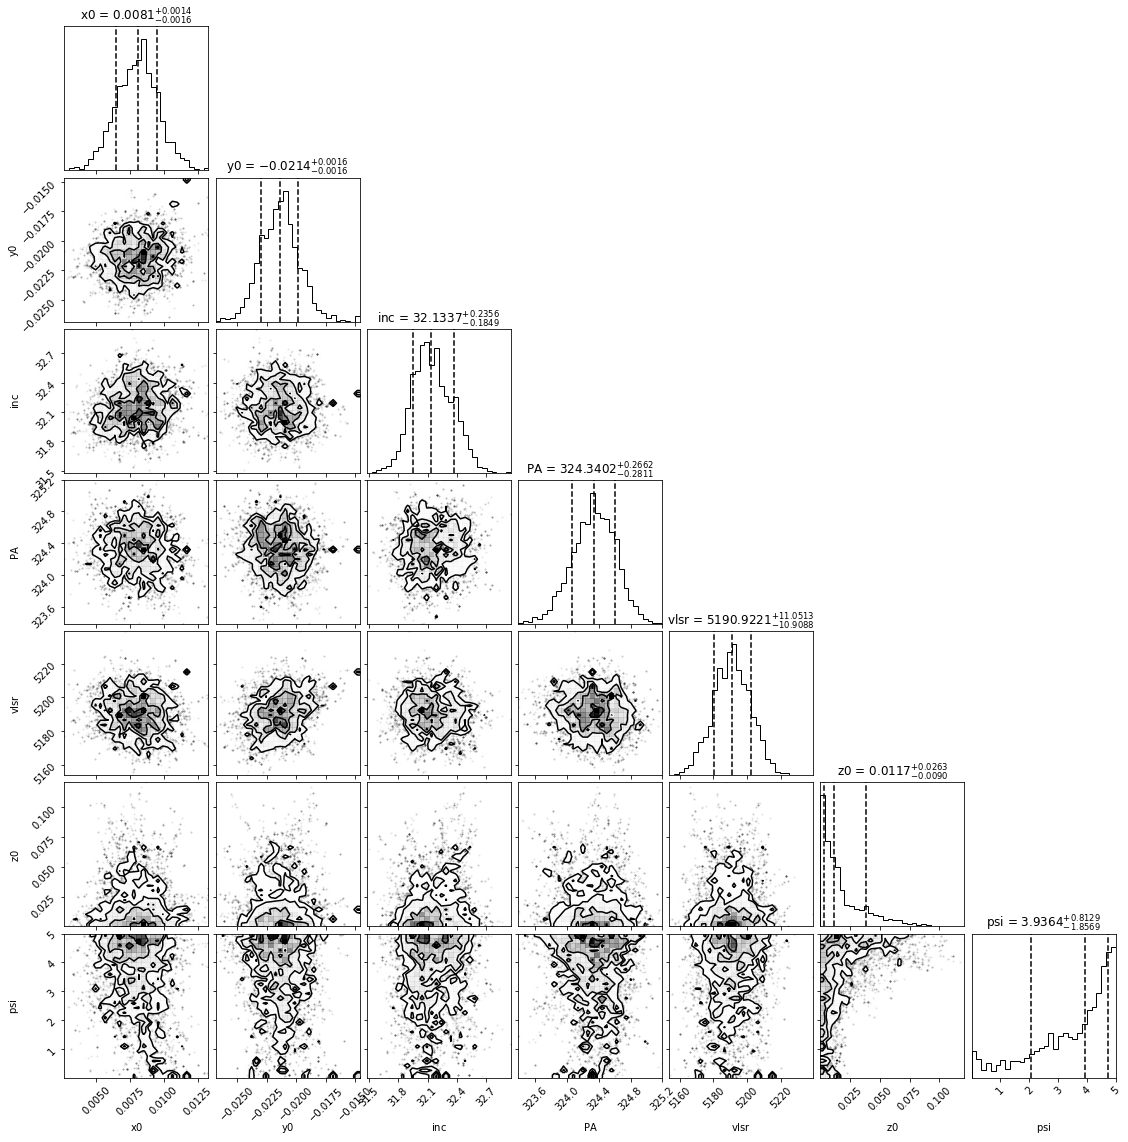

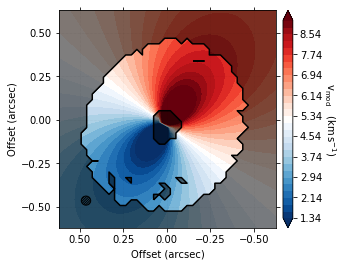

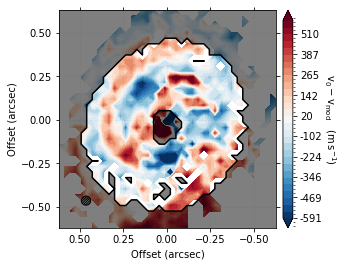

In [22]:
if not os.path.exists(os.path.join(path_working_place, t, iso, mode, f"{t}_mcmc_fit_rescaled.hdf5")):

    backend_mcmc_rescaled = emcee.backends.HDFBackend(os.path.join(path_working_place, t, iso, mode, f"{t}_mcmc_fit_rescaled.hdf5"))
    backend_mcmc_rescaled.reset(nwalkers, len(p0[mode][t]))


    percentiles_rescaled = cube_rescaled.fit_map(p0=p0[mode][t],
                               params=params,
                               r_min=float(fit_parameters['r_min'].data[mask_fit_params][0]) * cube.bmaj,
                               r_max=float(fit_parameters['r_max'].data[mask_fit_params][0]),
                               optimize=True,
                               nwalkers=nwalkers,
                               nburnin=nburnin,
                               nsteps=nsteps,
                               scatter=1e-3,
                               plots=None,
                               returns=None,
                               pool=None,
                               emcee_kwargs={
                                   'backend': backend_mcmc_rescaled,
                               },
                               niter=iterations,
                               shadowed=False)

In [23]:
sampler_rescaled = emcee.backends.HDFBackend(os.path.join(path_working_place, t, iso, mode, f"{t}_mcmc_fit_rescaled.hdf5"))
posteriors_rescaled = sampler_rescaled.get_chain(discard=(iterations - 1) * (nsteps + nburnin) + nburnin,
                                                 thin=1,
                                                 flat=True)

medians_rescaled = cube_rescaled._populate_dictionary(np.percentile(posteriors_rescaled, q=50, axis=0), params)
medians_rescaled = cube_rescaled.verify_params_dictionary(medians_rescaled)
medians_rescaled['r_min'] = float(fit_parameters['r_min'].data[mask_fit_params][0]) * cube_rescaled.bmaj
medians_rescaled['r_max'] = float(fit_parameters['r_max'].data[mask_fit_params][0])
medians_rescaled['abs_PA'] = False
medians_rescaled['exclude_r'] = False
cube_rescaled.ivar = cube_rescaled._calc_ivar(cube_rescaled._populate_dictionary(np.percentile(posteriors_rescaled, q=50, axis=0), medians_rescaled))

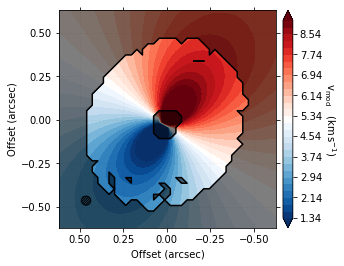

In [24]:
# Plot best-fit model
cube_rescaled._plot_bestfit(params=medians_rescaled,
                          ivar=cube_rescaled.ivar,
                          residual=False,
                          return_ax=False)

fig_2 = plt.gcf()

plt.show()
plt.close(fig_2)

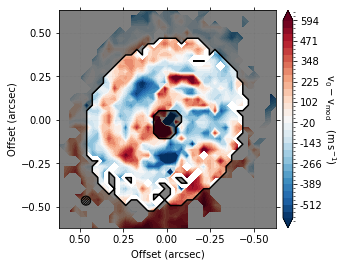

In [25]:
# Plot residuals
cube_rescaled._plot_residual(params=medians_rescaled,
                         ivar=cube_rescaled.ivar,
                         return_ax=False)

fig_3 = plt.gcf()

plt.show()
plt.close(fig_3)

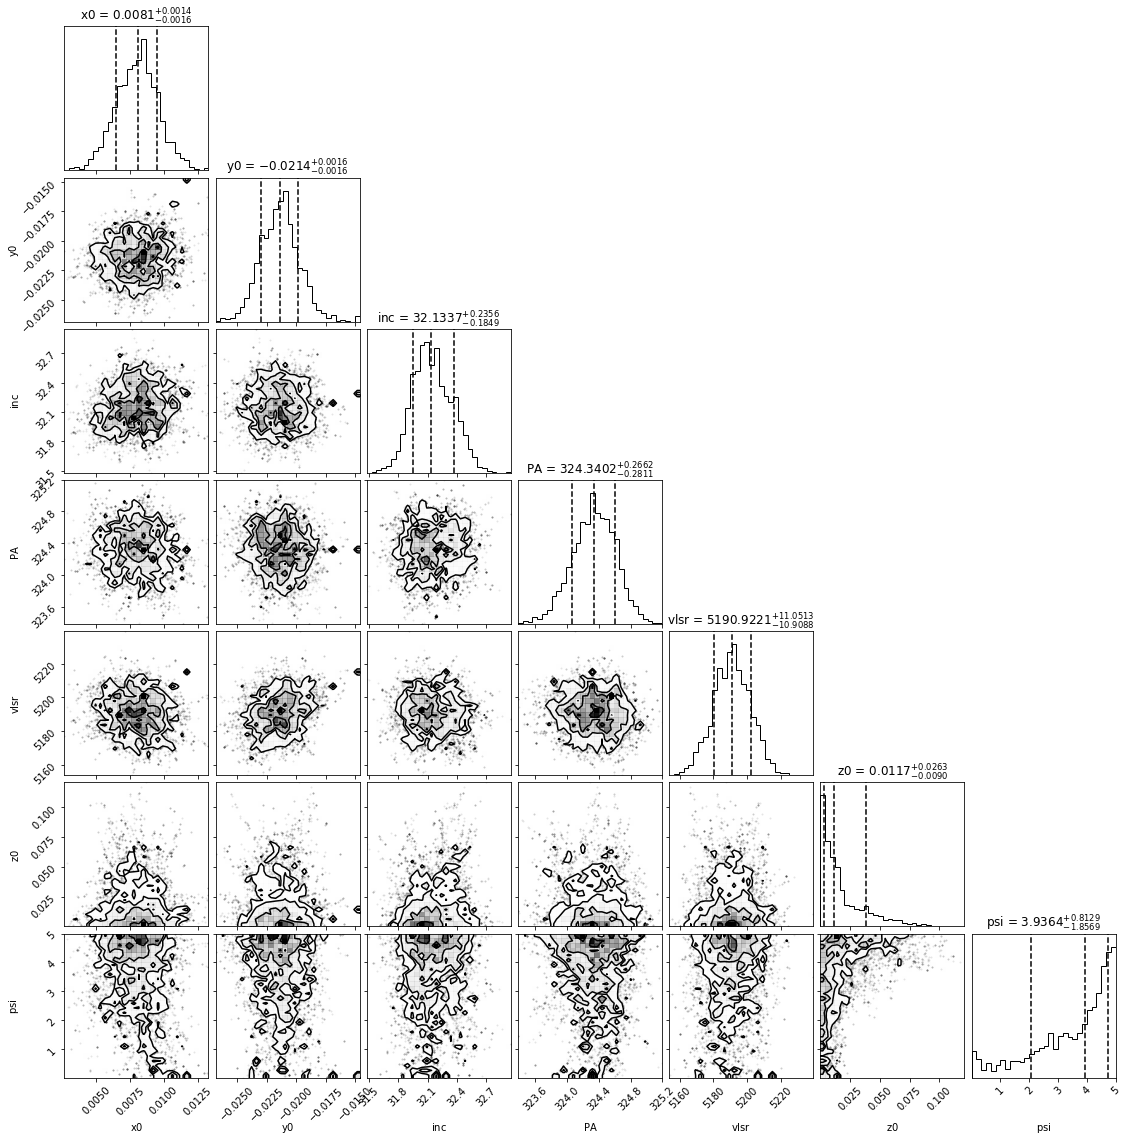

In [26]:
# Create corner plot
cube_rescaled._plot_corner(posteriors_rescaled,
                       cube_rescaled._get_labels(params),
                       quantiles=None)

fig_4 = plt.gcf()

plt.show()
plt.close(fig_4)